<a href="https://colab.research.google.com/github/meti-94/TextClassification/blob/main/hourly_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git -q
!pip install setuptools==58.2.0 -q

     |████████████████████████████████| 234 kB 21.7 MB/s 
     |████████████████████████████████| 176 kB 38.1 MB/s 
     |████████████████████████████████| 59.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 21.0 MB/s 
     |████████████████████████████████| 124 kB 53.4 MB/s 
     |████████████████████████████████| 150 kB 50.1 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
     |████████████████████████████████| 2.4 MB 38.0 MB/s 
     |████████████████████████████████| 153 kB 43.1 MB/s 
     |████████████████████████████████| 195 kB 54.2 MB/s 
     |████████████████████████████████| 90.8 MB 293 bytes/s 
     |████████████████████████████████| 448 kB 34.4 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 1.1 MB 35.6 MB/s 
     |████████████████████████████████| 1.1 MB 42.7 MB/s 
     |████████████████████████████████| 271 kB 53.8 MB/s 
     |████████████████████████████████| 3.6 MB 43.3 MB/s 
     |█████████

In [4]:
from finrl.apps import config
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
from datetime import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [6]:
def read_data(path):
    hist = pd.read_csv(path, parse_dates=True)
    hist = hist[hist.Timestamp>=1388521800]
    hist['date'] = hist['Timestamp'].apply(lambda item:datetime.fromtimestamp(item))
    hist.set_index('date', inplace=True)
    hist.dropna(inplace=True)
    return hist

def resampling(hist, timeframe='1min'):
    ohlc = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume_(BTC)':'sum'
    }
    df = hist.resample(timeframe, origin='end_day').apply(ohlc)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={'Open':'open', 'High':'high', 'Close':'close', 'Low':'low', 'Volume_(BTC)':'volume'}, inplace=True)
    df['date'] = df['date'].astype(str)
    df['tic'] = ['BTC' for _ in range(len(df))]
    df['day'] = [i%5 for i in range(len(df))]
    return df   
hist = read_data('/content/drive/MyDrive/kaggle_dataset/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
hist = hist['2014-01-01' :'2021-03-30']
hist = resampling(hist, timeframe='H')
df = hist

In [7]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_vix=False,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [8]:
processed

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2014-01-01 00:00:00,732.00,732.00,732.00,732.00,4.599562,BTC,0,0.000000,747.256282,724.713718,100.000000,66.666667,100.000000,732.000000,732.000000,0.000000
1,2014-01-01 01:00:00,732.01,739.97,729.01,739.97,585.497468,BTC,1,0.178814,747.256282,724.713718,100.000000,66.666667,100.000000,735.985000,735.985000,0.000000
2,2014-01-01 02:00:00,739.00,742.00,737.65,741.98,772.272334,BTC,2,0.290175,748.539892,727.426775,100.000000,99.300156,100.000000,737.983333,737.983333,0.000000
3,2014-01-01 03:00:00,741.98,757.99,741.98,747.20,1363.157561,BTC,3,0.522178,752.906569,727.668431,100.000000,120.000000,100.000000,740.287500,740.287500,0.000000
4,2014-01-01 04:00:00,747.20,749.61,740.00,744.99,369.706215,BTC,4,0.549311,752.937888,729.518112,86.469530,56.075982,84.310433,741.228000,741.228000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63386,2021-03-30 20:00:00,58851.42,59135.00,58733.00,59037.79,104.111136,BTC,1,456.662881,59819.267061,56815.273939,61.408259,99.766095,27.036958,58101.457333,57089.263000,0.163110
63387,2021-03-30 21:00:00,59014.42,59032.73,58402.82,58591.06,125.871531,BTC,2,414.187317,59823.809943,56924.306057,57.901628,62.010524,13.702231,58116.505667,57126.520167,0.958498
63388,2021-03-30 22:00:00,58592.54,58872.27,58570.57,58762.56,48.198945,BTC,3,389.869569,59807.521063,57091.784937,58.835166,63.703513,13.702231,58156.877667,57170.390167,0.139002
63389,2021-03-30 23:00:00,58787.45,58941.34,58642.58,58657.09,67.727386,BTC,4,357.960683,59746.824941,57298.832059,58.016687,60.388228,15.814539,58192.812333,57213.845000,0.054222


In [9]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(set(processed['date'].astype(str).to_list()))
combination = list(itertools.product(list_date,list_ticker))
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
processed_full = processed_full.fillna(0)
# print(list_ticker, list_date[:10], combination[:10])

In [10]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2014-01-01 00:00:00,BTC,732.00,732.00,732.00,732.00,4.599562,0,0.000000,747.256282,724.713718,100.000000,66.666667,100.000000,732.000000,732.000000,0.0
1,2014-01-01 01:00:00,BTC,732.01,739.97,729.01,739.97,585.497468,1,0.178814,747.256282,724.713718,100.000000,66.666667,100.000000,735.985000,735.985000,0.0
2,2014-01-01 02:00:00,BTC,739.00,742.00,737.65,741.98,772.272334,2,0.290175,748.539892,727.426775,100.000000,99.300156,100.000000,737.983333,737.983333,0.0
3,2014-01-01 03:00:00,BTC,741.98,757.99,741.98,747.20,1363.157561,3,0.522178,752.906569,727.668431,100.000000,120.000000,100.000000,740.287500,740.287500,0.0
4,2014-01-01 04:00:00,BTC,747.20,749.61,740.00,744.99,369.706215,4,0.549311,752.937888,729.518112,86.469530,56.075982,84.310433,741.228000,741.228000,0.0
5,2014-01-01 05:00:00,BTC,744.99,749.59,744.99,749.52,173.797256,0,0.749002,755.081382,730.138618,89.486059,75.301306,84.310433,742.610000,742.610000,0.0
6,2014-01-01 06:00:00,BTC,745.84,749.99,745.84,749.90,189.560775,1,0.881379,756.299783,731.003075,89.685607,69.649269,84.589507,743.651429,743.651429,0.0
7,2014-01-01 07:00:00,BTC,749.80,749.88,741.20,745.89,110.683557,2,0.765256,755.747851,732.114649,74.292964,32.796954,51.233225,743.931250,743.931250,0.0
8,2014-01-01 08:00:00,BTC,745.00,749.99,741.02,746.85,313.025197,3,0.720828,755.478938,733.032173,75.341092,35.044239,50.108377,744.255556,744.255556,0.0
9,2014-01-01 09:00:00,BTC,746.85,750.06,741.12,742.00,679.667299,4,0.429005,754.707232,733.352768,62.106935,13.077603,50.262165,744.030000,744.030000,0.0


In [11]:
processed_full.sort_values(['date','tic'],ignore_index=True).tail(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
63381,2021-03-30 15:00:00,BTC,58932.33,59039.61,58615.12,58910.90,128.390431,1,551.744505,59501.042940,56500.061060,61.303323,135.587261,28.079353,57967.518333,56872.005000,0.008427
63382,2021-03-30 16:00:00,BTC,58904.18,58921.10,58430.09,58661.86,209.161336,2,521.769272,59570.035304,56525.535696,59.468522,98.368261,21.325479,57990.972667,56913.885833,0.302037
63383,2021-03-30 17:00:00,BTC,58661.86,58841.28,58445.17,58717.03,96.402327,3,496.739340,59617.659692,56631.216308,59.744634,90.314149,21.325479,58012.405000,56953.794167,0.012902
63384,2021-03-30 18:00:00,BTC,58735.91,58885.00,58673.96,58747.94,61.725871,4,473.933903,59671.761990,56707.195010,59.902950,94.796664,22.429897,58041.872000,56994.350667,0.003513
63385,2021-03-30 19:00:00,BTC,58773.82,59144.94,58773.82,58849.28,198.557621,0,458.749541,59737.220028,56760.599972,60.430744,104.344750,28.783724,58066.568000,57042.739667,0.044748
63386,2021-03-30 20:00:00,BTC,58851.42,59135.00,58733.00,59037.79,104.111136,1,456.662881,59819.267061,56815.273939,61.408259,99.766095,27.036958,58101.457333,57089.263000,0.163110
63387,2021-03-30 21:00:00,BTC,59014.42,59032.73,58402.82,58591.06,125.871531,2,414.187317,59823.809943,56924.306057,57.901628,62.010524,13.702231,58116.505667,57126.520167,0.958498
63388,2021-03-30 22:00:00,BTC,58592.54,58872.27,58570.57,58762.56,48.198945,3,389.869569,59807.521063,57091.784937,58.835166,63.703513,13.702231,58156.877667,57170.390167,0.139002
63389,2021-03-30 23:00:00,BTC,58787.45,58941.34,58642.58,58657.09,67.727386,4,357.960683,59746.824941,57298.832059,58.016687,60.388228,15.814539,58192.812333,57213.845000,0.054222
63390,2021-03-31 00:00:00,BTC,58651.94,58770.38,58567.11,58760.59,78.047558,0,337.137930,59619.899090,57596.703910,58.601331,51.800440,12.595492,58221.545667,57264.520167,0.049842


In [12]:
train = data_split(processed_full, '2014-01-01','2019-12-30')
trade = data_split(processed_full, '2019-12-30','2021-03-30')
print(len(train))
print(len(trade))

52426
10940


In [13]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
52421,2019-12-29 19:00:00,BTC,7403.67,7424.47,7389.42,7422.20,38.803954,1,29.626098,7423.128040,7242.663960,61.535741,205.317665,43.242780,7325.234667,7281.116167,0.730651
52422,2019-12-29 20:00:00,BTC,7421.29,7468.31,7401.65,7450.68,116.800849,2,34.109793,7443.477090,7236.987910,63.513866,227.054270,52.934258,7330.777667,7285.952667,0.640691
52423,2019-12-29 21:00:00,BTC,7446.86,7524.46,7338.91,7390.79,977.902603,3,32.456394,7448.281962,7241.832038,57.123196,158.210388,21.258978,7333.751667,7289.562667,3.244298
52424,2019-12-29 22:00:00,BTC,7389.58,7399.19,7355.00,7381.77,69.290714,4,30.071579,7449.427295,7251.264705,56.241518,77.737595,21.258978,7336.916333,7293.270500,0.093578
52425,2019-12-29 23:00:00,BTC,7382.38,7424.73,7380.15,7381.29,27.279854,0,27.822147,7450.566805,7259.333195,56.193771,98.209377,28.178468,7339.198333,7296.771000,0.002338


In [14]:
train.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2014-01-01 00:00:00,BTC,732.00,732.00,732.00,732.00,4.599562,0,0.000000,747.256282,724.713718,100.00000,66.666667,100.000000,732.000000,732.000000,0.0
1,2014-01-01 01:00:00,BTC,732.01,739.97,729.01,739.97,585.497468,1,0.178814,747.256282,724.713718,100.00000,66.666667,100.000000,735.985000,735.985000,0.0
2,2014-01-01 02:00:00,BTC,739.00,742.00,737.65,741.98,772.272334,2,0.290175,748.539892,727.426775,100.00000,99.300156,100.000000,737.983333,737.983333,0.0
3,2014-01-01 03:00:00,BTC,741.98,757.99,741.98,747.20,1363.157561,3,0.522178,752.906569,727.668431,100.00000,120.000000,100.000000,740.287500,740.287500,0.0
4,2014-01-01 04:00:00,BTC,747.20,749.61,740.00,744.99,369.706215,4,0.549311,752.937888,729.518112,86.46953,56.075982,84.310433,741.228000,741.228000,0.0


In [15]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [16]:
env_kwargs = {
    "hmax": 10, 
    "initial_amount": 100000, 
    "buy_cost_pct": 0.0001,
    "sell_cost_pct": 0.0001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-3
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [17]:
env_train, _ = e_train_gym.get_sb_env()

In [18]:
agent = DRLAgent(env = env_train)

In [19]:

model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [41]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

------------------------------------
| time/                 |          |
|    fps                | 122      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -2.5     |
|    explained_variance | -15.4    |
|    learning_rate      | 0.0007   |
|    n_updates          | 10099    |
|    policy_loss        | 0.00887  |
|    reward             | 0.02451  |
|    std                | 2.95     |
|    value_loss         | 0.0213   |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 123       |
|    iterations         | 200       |
|    time_elapsed       | 8         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -2.52     |
|    explained_variance | -0.939    |
|    learning_rate      | 0.0007    |
|    n_updates          | 10

In [51]:
data_risk_indicator = processed_full[(processed_full.date<'2019-12-30') & (processed_full.date>='2014-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [52]:
insample_risk_indicator.turbulence.describe()

count    52426.000000
mean         1.271149
std         15.548509
min          0.000000
25%          0.034078
50%          0.186731
75%          0.718615
max       2893.306061
Name: turbulence, dtype: float64

In [78]:
insample_risk_indicator.turbulence.quantile(0.996)

30.391485456357874

In [81]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 30,risk_indicator_col='turbulence', **env_kwargs)

In [82]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2019-12-30 00:00:00,BTC,7382.31,7410.13,7372.79,7373.31,53.818727,1,25.106129,7449.846551,7268.484449,55.385113,74.377567,24.800088,7340.732000,7301.369000,0.070815
1,2019-12-30 01:00:00,BTC,7374.61,7375.80,7302.35,7336.07,110.967154,2,19.721372,7446.291512,7277.135488,51.787366,-5.291391,1.705044,7341.378333,7303.239667,1.284577
2,2019-12-30 02:00:00,BTC,7336.89,7352.17,7324.14,7343.70,76.722328,3,15.886462,7444.933374,7281.855626,52.442150,-2.601530,1.705044,7341.760000,7306.163333,0.042785
3,2019-12-30 03:00:00,BTC,7343.70,7361.60,7328.36,7348.96,51.321847,4,13.120462,7443.757477,7286.420523,52.898352,6.908682,1.495265,7342.661667,7308.866000,0.015520
4,2019-12-30 04:00:00,BTC,7348.85,7355.00,7329.00,7339.00,34.250768,0,10.009316,7441.827987,7291.346013,51.922713,-3.480803,1.495265,7343.565000,7311.019000,0.112603


In [83]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [84]:
df_account_value.shape

(10940, 2)

In [85]:
df_account_value.tail()

,date,account_value
10935,2021-03-29 19:00:00,134134.104835
10936,2021-03-29 20:00:00,133868.224835
10937,2021-03-29 21:00:00,133856.681397
10938,2021-03-29 22:00:00,134371.544601
10939,2021-03-29 23:00:00,134360.055175


In [86]:
df_actions.tail(100)

,date,actions
10839,2021-03-25 19:00:00,[0]
10840,2021-03-25 20:00:00,[0]
10841,2021-03-25 21:00:00,[0]
10842,2021-03-25 22:00:00,[2]
10843,2021-03-25 23:00:00,[0]
...,...,...
10934,2021-03-29 18:00:00,[0]
10935,2021-03-29 19:00:00,[0]
10936,2021-03-29 20:00:00,[-2]
10937,2021-03-29 21:00:00,[2]


In [87]:
print("==============Get Backtest Results===========")
now = datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.006827
Cumulative returns     0.343601
Annual volatility      0.091749
Sharpe ratio           0.120550
Calmar ratio           0.016467
Stability              0.484536
Max drawdown          -0.414552
Omega ratio            1.033690
Sortino ratio          0.164583
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.048305
Daily value at risk   -0.011515
dtype: float64


In [88]:
df_account_value.loc[0,'date'].split()[0]

'2019-12-30'

In [89]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="BTC", 
        start = df_account_value.loc[0,'date'].split()[0],
        end = df_account_value.loc[len(df_account_value)-1,'date'].split()[0])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (122, 8)
Annual return         -0.027990
Cumulative returns    -0.013650
Annual volatility      0.016371
Sharpe ratio          -1.740263
Calmar ratio          -1.670948
Stability              0.520286
Max drawdown          -0.016751
Omega ratio            0.713341
Sortino ratio         -2.054830
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.612128
Daily value at risk   -0.002176
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (122, 8)


Start date,2019-12-30
End date,2021-03-29
Total months,520
,Backtest
Annual return,0.683%
Cumulative returns,34.36%
Annual volatility,9.175%
Sharpe ratio,0.12
Calmar ratio,0.02
Stability,0.48
Max drawdown,-41.455%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,41.46,2020-01-14,2020-03-13,2020-08-17,154
1,39.11,2021-01-03,2021-01-31,NaT,NaN
2,18.23,2020-08-17,2020-09-04,2020-10-21,48
3,12.01,2020-12-01,2020-12-11,2020-12-17,12
4,9.90,2020-12-20,2020-12-25,2020-12-27,5


Stress Events,mean,min,max
New Normal,0.00%,-17.55%,8.05%


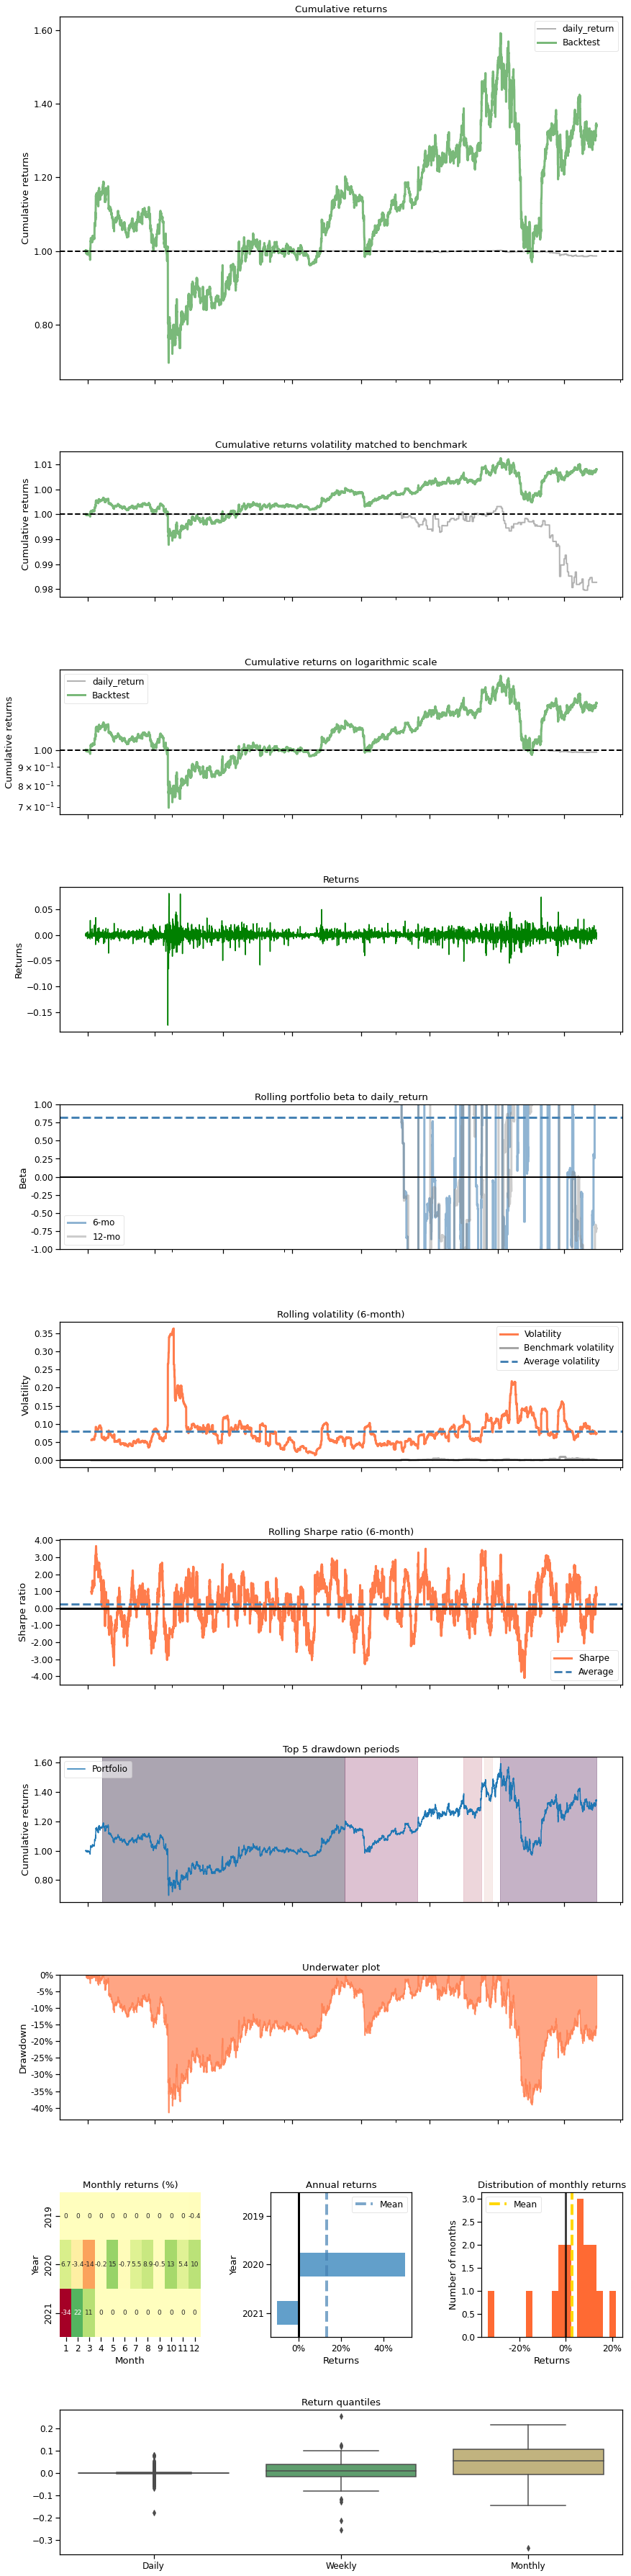

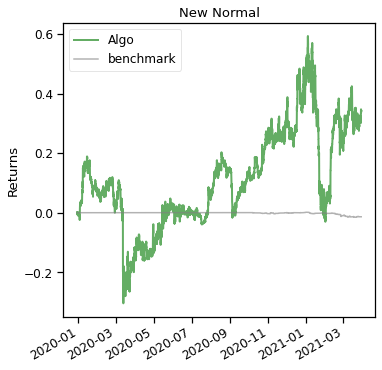

In [90]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = 'BTC', 
             baseline_start = df_account_value.loc[0,'date'].split()[0],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'].split()[0])

In [91]:
df_account_value.account_value.min()

69583.04095200085